# Prevalence of Personal Attacks


- What fraction of comments are personal attacks?

- What fraction of users have made a personal attack?

- What fraction of users have been blocked or warned?

- What fraction of users have been attacked?

- trend over years

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *
from analysis_utils import compare_groups

In [2]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

### Q: What fraction of comments are personal attacks?

#### Methodology 1:
Compute fraction of comments predicted to be attacks for different classification thresholds

In [109]:
def prevalence_m1(d, sample, score, ts = np.arange(0.5, 0.91, 0.1)):

    d_a = pd.concat([pd.DataFrame({'threshold': t, 'attack': d[sample].query("ns=='article'")[score] >= t }) for t in ts], axis = 0)
    d_a['condition'] = 'article talk'

    d_u = pd.concat([pd.DataFrame({'threshold': t, 'attack': d[sample].query("ns=='user'")[score] >= t }) for t in ts], axis = 0) 
    d_u['condition'] = 'user talk'

    df = pd.concat([d_u, d_a])
    df['attack'] = df['attack'] * 100
    sns.pointplot(x="threshold", y="attack", hue="condition", data=df)
    plt.ylabel('percent of comments that are attacks')
    plt.ylim(-0.1, plt.ylim()[1])
    plt.savefig('../../paper/figs/threshold_prevalence_%s_%s' % (sample, score))


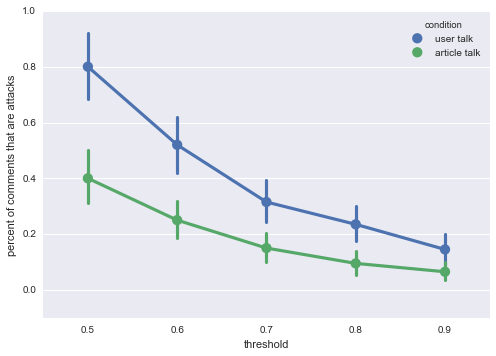

In [110]:
prevalence_m1(d, 'annotated', 'recipient_score')

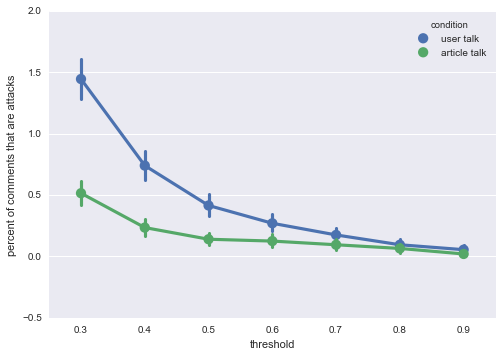

In [64]:
prevalence_m1(d, 'annotated', 'pred_recipient_score')

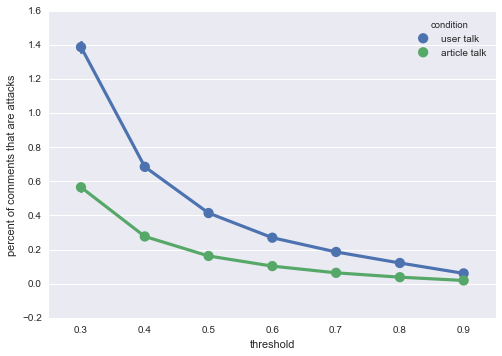

In [65]:
prevalence_m1(d, 'sample', 'pred_recipient_score')

#### Methodology 2
For each comment, label it as a personal attack with the probability assigned by the model/annotators. Count the number of comments labeled as personal attacks. Repeat to get a distribtion and take 95% interval.

In [76]:
def prevalence_m2(d, sample, score, n = 10):
    def compute_ci(a, n = 10):
        m = a.shape[0]
        v = a.values.reshape((m,1))
        fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
        print("Percent of comments labeled as attacks: (%.3f, %.3f)" % ( 100*np.percentile(fs, 2.5), 100*np.percentile(fs, 97.5)))
    
    print('\nUser:')
    compute_ci(d[sample].query("ns=='user'")[score])
    print('Article:')
    compute_ci(d[sample].query("ns=='user'")[score])

In [94]:
prevalence_m2(d, 'annotated', 'recipient_score')


User:
Percent of comments labeled as attacks: (3.740, 4.167)
Article:
Percent of comments labeled as attacks: (3.603, 4.065)


In [95]:
prevalence_m2(d, 'annotated', 'pred_recipient_score')


User:
Percent of comments labeled as attacks: (6.079, 6.783)
Article:
Percent of comments labeled as attacks: (6.497, 6.839)


In [96]:
prevalence_m2(d, 'sample', 'pred_recipient_score')


User:
Percent of comments labeled as attacks: (6.671, 6.726)
Article:
Percent of comments labeled as attacks: (6.628, 6.714)


The model over-predicts relative to the annotators for method M2, since models score distribution is skewed right in the [0, 0.2] interval and that where most of the data is.

### Q: What fraction of users have made a personal attack?

#### Methodology 1:
Take unsampled data from 2015. Compute fraction of people who authored one comment above the threshold for different thresholds.

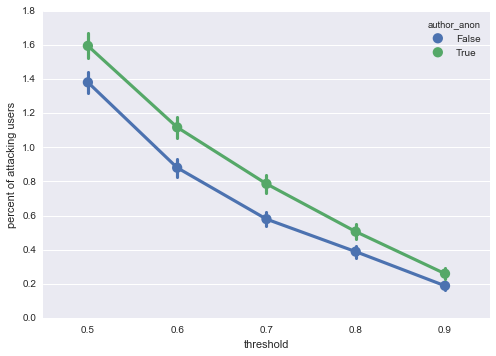

In [78]:
ts = np.arange(0.5, 0.91, 0.1)
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].assign(attack= lambda x: 100 * (x.pred_recipient_score > t))\
                .groupby(['user_text', 'author_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'author_anon', data = pd.concat(dfs))
plt.ylabel('percent of attacking users')

#### Methodology 2:
Take unsampled data. For each comment, let it be an attack with proabbility equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [82]:
def simulate_num_attacks(df, group_col = 'user_text', bias = 0.0):
    n = df.assign( uniform = np.random.rand(df.shape[0], 1))\
            .assign(is_attack = lambda x: ((x.pred_recipient_score_oh + bias) > x.uniform).astype(int))\
            .groupby(group_col)['is_attack']\
            .max()\
            .sum()
    return n

In [83]:
n_attacks = [simulate_num_attacks(d['2015']) for i in range(100)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].user_text.unique()))  

array([ 14.67803572,  14.90957   ])

In [84]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp) for i in range(100)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.user_text.unique())) 

array([ 17.78616401,  18.11723669])

Note: these results are inflated, due to models right skew. This means that users with a lot of comments are very likely to be assigned at least one attacking comment in the simulation.

### Q: What fraction of users have been attacked on their user page?

#### Methodology:
Take unsampled data from 2015. Compute fraction of people who recieved one comment above the threshold for different thresholds. 

TODO: why have there been so many more attackers than victims? 
- attacks can happen on article pages too
- do attacks cluster around individuals
- compute ratio of attacks received by user and order user by that ratio.


Note: do not include comments made by the user on their own page. Do not include article ns comments

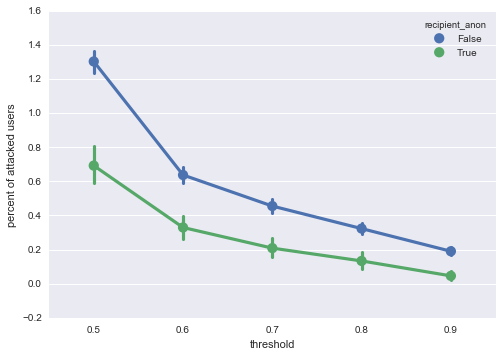

In [85]:
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].query("not own_page and ns=='user'")\
                .assign(attack = lambda x: 100 * (x.pred_recipient_score >= t))\
                .groupby(['page_title', 'recipient_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'recipient_anon', data = pd.concat(dfs))
plt.ylabel('percent of attacked users')

#### Methodology 2:
Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have received at least 1 attack. Repeat.

In [87]:
n_attacks = [simulate_num_attacks(d['2015'].query("ns=='user'"), group_col = 'page_title') for i in range(10)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].page_title.unique()))

array([ 5.67562828,  5.7106639 ])

In [90]:
# ignore anon users and attackers
d_temp = d['2015'].query("not author_anon and not recipient_anon and ns=='user'")
n_attacks = [simulate_num_attacks(d_temp, group_col = 'page_title') for i in range(10)]        
100 * (np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.page_title.unique()))

array([ 15.29736317,  15.54200827])

### Q: Has the amount of aggressiveness and attacks changed year over year?

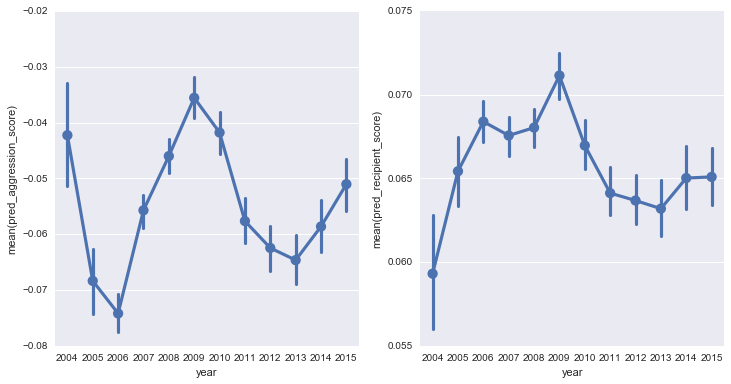

In [91]:
df_span = d['sample'][:100000].query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
compare_groups(df_span, x, order = o, table = False)

### Q: Is there a seasonal effect?

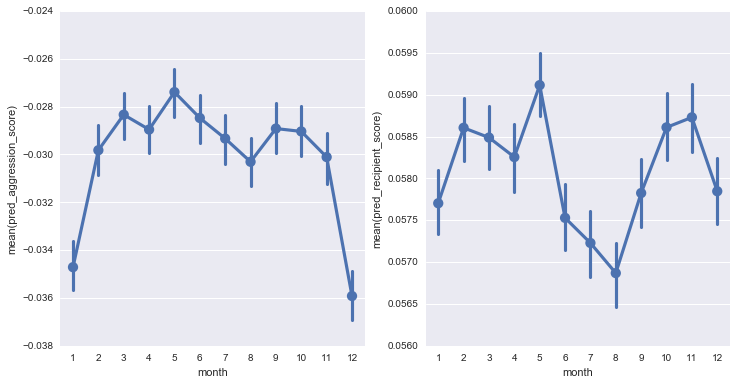

In [92]:
x = 'month'
o = range(1, 13)
compare_groups(d['sample'], x, order = o, table = False)

### Q: Is there an hour of day effect?

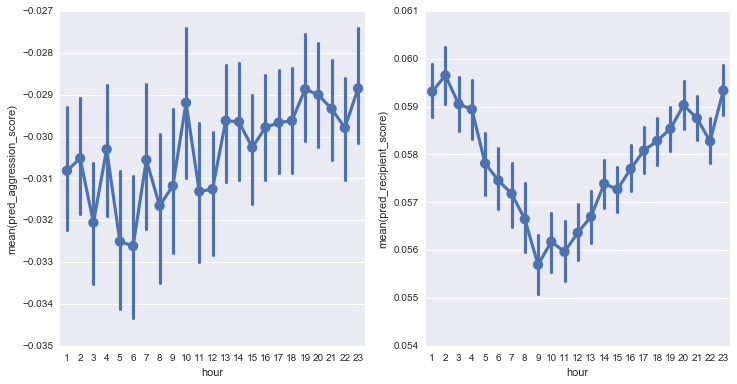

In [93]:
x = 'hour'
o  = range(1, 24)
compare_groups(d['sample'], x, order = o, table = False)